[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v1.ipynb)

# Система распознавания дорожных знаков на датасете RTSD
## Простой вариант обучения Faster R-CNN для детекции 155 классов (слабый baseline)

In [57]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip -d ./data/RTSD
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD/
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    !pip install fiftyone

dataset_path = 'data/RTSD'
checkpoints_path = 'checkpoints'
model_name = 'resnet50v2_all_classes'

In [60]:
import os
import time

from PIL import Image
from pycocotools.coco import COCO

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### Гиперпараметры

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

n_epochs = 10
batch_size = 8
num_classes = 156

NVIDIA GeForce RTX 3090


### Загрузчик данных

In [30]:
class RTSD_dataset(Dataset):
    '''
    Faster R-CNN при обучении ожидает на вход:
    - список тензоров размерностью [C, H, W] для каждого изображения со значениями в диапазоне 0-1
    - таргет: список словарей с ключами:
                - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
                - labels (Int64Tensor[N]): the class label for each ground-truth box (including the background)
    '''
    
    
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)
        
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [31]:
# ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

### Формирование батча

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
train_dataset = RTSD_dataset(root=dataset_path,
                             annotation=os.path.join(dataset_path, 'train_anno.json'),
                             transforms=get_transform()
                             )

val_dataset = RTSD_dataset(root=dataset_path,
                           annotation=os.path.join(dataset_path, 'val_anno.json'),
                           transforms=get_transform()
                           )

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### Инициализация модели, задание оптимизатора и функции потерь

In [51]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [63]:
model = create_model(num_classes=156, pretrained=True).to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

### Трейн луп

In [64]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на обучающей выборке. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    len_dataloader = len(val_dataloader)
    running_loss = 0
    for i, data in enumerate(val_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader} на тестовой выборке. Loss: {loss}")
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [65]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))

except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774 на обучающей выборке. Loss: 5.5149006843566895
	Эпоха 0. Итерация 50/6774 на обучающей выборке. Loss: 0.33971184492111206
	Эпоха 0. Итерация 100/6774 на обучающей выборке. Loss: 0.36685270071029663
	Эпоха 0. Итерация 150/6774 на обучающей выборке. Loss: 0.42015552520751953
	Эпоха 0. Итерация 200/6774 на обучающей выборке. Loss: 0.3724037706851959


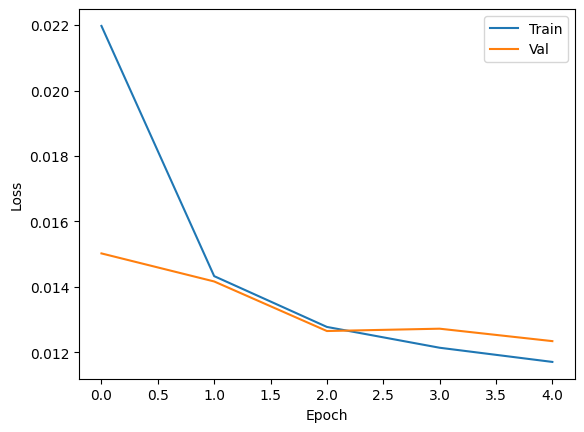

In [23]:
%matplotlib inline
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import fiftyone as fo

In [ ]:
During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format, with
          ``0 <= x1 < x2 <= W`` and ``0 <= y1 < y2 <= H``.
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction
